In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow===2.3.0

In [18]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
'''!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

!pip install technical
!pip install freqtrade'''

'!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz\n!tar -xzvf ta-lib-0.4.0-src.tar.gz\n%cd ta-lib\n!./configure --prefix=/usr\n!make\n!make install\n!pip install Ta-Lib\n\n!pip install technical\n!pip install freqtrade'

In [ ]:
!apt-get install unzip
!pip install mplfinance
!pip install keras
!pip install keras-rl2
#!pip install tensorflow
!pip install talib-binary
!pip install ta
#!pip install technical
!pip install binance_data

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from statistics import mean, median, stdev
import random
from collections import deque
import time
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import os
import sys
import shutil
import cv2
from google.colab.patches import cv2_imshow

from sklearn import preprocessing
from rl.agents import DQNAgent
from rl.policy import LinearAnnealedPolicy, SoftmaxPolicy, EpsGreedyQPolicy, GreedyQPolicy, BoltzmannQPolicy, MaxBoltzmannQPolicy, BoltzmannGumbelQPolicy
from rl.memory import SequentialMemory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

from google.colab import output

from talib import RSI, ULTOSC, ADX, MINUS_DI, PLUS_DI, MFI, HT_TRENDLINE, MIDPOINT, BBANDS, MACD, AD, OBV, ADOSC, APO, AROONOSC, STOCHRSI, CMO, BOP, TRANGE, SAR, PPO, WILLR, ROC, MAMA, ATR
import ta
from binance_data import DataClient

In [2]:
def get_data(ticker='BTCUSDT', interval='1h', futures=True, decimals=0, progress_statements=True,):
  if futures:
    directory='/data/binance_data_futures/'
  else:
    directory='/data/binance_data_spot/'

  ### If inside colab notebook ###
  if 'google.colab' in sys.modules:
    !rm -r /content/data/
    drive_path='/content/drive/MyDrive/RLtrader'+directory+interval+'_data/'+ticker
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)
        print(f'created dir {drive_path}')

    # move already downloaded data from google drive to working dir
    local_dir = '/content'+directory+interval+'_data/'+ticker
    shutil.move(drive_path, local_dir)

    # refill with newer data 
    print('\n updating data...')
    store_data = DataClient(futures=futures).kline_data([ticker.upper()], interval, storage=['csv', os.getcwd()+directory], progress_statements=progress_statements)
    local_dir_updated=os.getcwd()+directory+interval+'_data/'+ticker
    shutil.move(local_dir_updated, drive_path)

    tckr_df = pd.read_csv(drive_path+'/'+ticker+'.csv', header=0)
    return tckr_df
  else:
    local_dir=os.getcwd()+directory+interval+'_data/'+ticker
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)
        print(f'created dir {local_dir}')
    print('\n updating data...')
    store_data = DataClient(futures=futures).kline_data([ticker.upper()], interval, storage=['csv', os.getcwd()+directory], progress_statements=progress_statements)
    local_dir_updated=os.getcwd()+directory+interval+'_data/'+ticker

    tckr_df = pd.read_csv(local_dir_updated+'/'+ticker+'.csv', header=0)
    return tckr_df

In [3]:
def check_df(seconds, dir, itv, tckr, futures):
  try:
    if 'google.colab' in sys.modules:
      full_path='/content/drive/MyDrive/RLtrader'+dir+itv+'_data/'+tckr+'.csv'
    else:
      full_path=os.getcwd()+dir+itv+'_data/'+tckr+'/'+tckr+'.csv'
    tckr_df = pd.read_csv(full_path)
    #tckr_df['Opened'] = pd.to_datetime(tckr_df['Opened'])
    timestamp_last = pd.to_datetime(tckr_df.iloc[-1]['Opened']).value // 10 ** 9
    diff=time.time()-timestamp_last
    print(f' avg gain/loss data is of by {diff} timestamps')
    # checking how many seconds old the local df is
    if diff>seconds:
      raise FileNotFoundError("Out of date dataframe (1day)")
    return tckr_df
  except FileNotFoundError:
    return get_data(ticker=tckr, interval=itv, futures=futures)

In [4]:
def get_levels(ticker='BTCUSDT', interval='1m',  futures=True, decimals=0, current_price_offset=15,volume_above_avg=False):
  ### get data ###
  if futures:
    directory='/data/binance_data_futures/'
  else:
    directory='/data/binance_data_spot/'
  tckr_df = check_df(86400, directory, interval, ticker, futures)

  ### searchin for lvls ###
  vol_array=tckr_df['Volume'][1:].to_numpy()
  avg_vol=np.mean(vol_array)
  tckr_lvls={}
  for open, close, volume, close_next in zip(tckr_df['Open'][:-1].to_numpy(), tckr_df['Close'][:-1].to_numpy(), vol_array, tckr_df['Close'][1:].to_numpy()):
    #if (not volume_above_avg or volume>=avg_vol) and band_top>close>band_bottom:
    if (close>open>close_next) or (close<open<close_next):
      close=round(close, decimals)
      if close in tckr_lvls:
        tckr_lvls[close]+=1
      else:
        tckr_lvls[close]=1
      if volume>=avg_vol:
        tckr_lvls[close]+=1
      #print(row)
  tckr_lvls={k: v for k, v in sorted(tckr_lvls.items(), key=lambda item: item[1], reverse=True)}
  #print(tckr_lvls)
  return tckr_lvls

In [5]:
def get_avg_changes(ticker='BTCUSDT', interval='1m', futures=True):
  ### get data ###
  if futures:
    directory='/data/binance_data_futures/'
  else:
    directory='/data/binance_data_spot/'
  tckr_df = check_df(86400, directory, interval, ticker, futures)

  open_array=tckr_df['Open'].to_numpy()
  close_array=tckr_df['Close'].to_numpy()
  #low_array=tckr_df['Low'].to_numpy()
  #high_array=tckr_df['High'].to_numpy()
  #vol_array=tckr_df['Volume'].to_numpy()

  gain = [ (close/open-1)*100 for open, close in zip(open_array, close_array) if close>open]
  loss = [ (open/close-1)*100 for open, close in zip(open_array, close_array) if close<open]
  #HL_distance = [ (high/low-1)*100 for low, high in zip(low_array, high_array)]

  #avg_vol=np.mean(vol_array)
  #stdev_vol=np.std(vol_array)
  #print(f'interval: {interval} avg_gain: {mean(gain)} stdev: {stdev(gain)} avg_loss: {mean(loss)} stdev: {stdev(loss)}')
  #print(f'avg_volume: {avg_vol} stdev: {stdev_vol} avg_High_Low_distance: {mean(HL_distance)} stdev: {stdev(HL_distance)}')
  return mean(gain),stdev(gain),mean(loss),stdev(loss)

In [6]:
##### SIGNAL GENERATORS #####
#############################
def Hour_strat(hour_col):
  h_dict={ 0:1, 1:-2, 2:-4, 3:-4, 4:-1, 5:1, 6:2, 7:1, 8:0, 9:-3, 10:-1, 11:1, 12:1,
      13:3, 14:-3, 15:2, 16:1, 17:-1, 18:1, 19:3, 20:0, 21:4, 22:4, 23:-2 }
  Hour_sig=[]
  for i in range(len(hour_col)):
    Hour_sig.append(h_dict[hour_col.iloc[i]])
  return Hour_sig

def Weekday_strat(column):
  wd_dict={ 0:-1, 1:1, 2:0, 3:2, 4:-2, 5:1, 6:1 }
  Weekday_sig=[]
  for i in range(len(column)):
    Weekday_sig.append(wd_dict[column.iloc[i]])
  return Weekday_sig

def ULT_RSI_strat(column):
  signals=[0]
  for i in range(1,len(column)):
    # Overbought
    if column.iloc[i-1]>65.0:
      signals.append(-1)
    # Oversold
    elif column.iloc[i-1]<35.0:
      signals.append(1)
    # Sell singal
    elif column.iloc[i-1]>65.0 and column.iloc[i]<65.0:
      signals.append(-2)
    # Buy singal
    elif column.iloc[i-1]<35.0 and column.iloc[i]>35.0:
      signals.append(2)
    else:
      signals.append(0)
  return signals

def ADX_strat(adx_col,minus_DI,plus_DI):
  signals=[0]
  for i in range(1,len(adx_col)):
    # Strong BUY signal
    if plus_DI.iloc[i]>minus_DI.iloc[i] and plus_DI.iloc[i-1]<minus_DI.iloc[i-1] and adx_col.iloc[i]>25.0:
      signals.append(4)
    # BUY signal
    elif plus_DI.iloc[i]>minus_DI.iloc[i] and plus_DI.iloc[i-1]<minus_DI.iloc[i-1] and adx_col.iloc[i]>20.0:
      signals.append(3)

    # Strong SELL signal
    elif plus_DI.iloc[i]<minus_DI.iloc[i] and plus_DI.iloc[i-1]>minus_DI.iloc[i-1] and adx_col.iloc[i]>25.0:
      signals.append(-4)
    # SELL signal
    elif plus_DI.iloc[i]<minus_DI.iloc[i] and plus_DI.iloc[i-1]>minus_DI.iloc[i-1] and adx_col.iloc[i]>20.0:
      signals.append(-3)
    
    # strong heading toward BUY
    elif plus_DI.iloc[i]>plus_DI.iloc[i-1] and minus_DI.iloc[i]<minus_DI.iloc[i-1] and plus_DI.iloc[i]<minus_DI.iloc[i] and adx_col.iloc[i]>25.0:
      signals.append(2)
    # strong heading toward SELL
    elif plus_DI.iloc[i]<plus_DI.iloc[i-1] and minus_DI.iloc[i]>minus_DI.iloc[i-1] and plus_DI.iloc[i]>minus_DI.iloc[i] and adx_col.iloc[i]>25.0:
      signals.append(-2)

    # heading toward BUY
    elif plus_DI.iloc[i]>plus_DI.iloc[i-1] and minus_DI.iloc[i]<minus_DI.iloc[i-1] and plus_DI.iloc[i]<minus_DI.iloc[i] and adx_col.iloc[i]>20.0:
      signals.append(1)
    # heading toward SELL
    elif plus_DI.iloc[i]<plus_DI.iloc[i-1] and minus_DI.iloc[i]>minus_DI.iloc[i-1] and plus_DI.iloc[i]<minus_DI.iloc[i] and adx_col.iloc[i]>20.0:
      signals.append(-1)
    else:
      signals.append(0)
  return signals

def ADX_trend(column):
  signals=[0]
  for i in range(1,len(column)):
    # Strong trend
    if column.iloc[i]>25.0:
      signals.append(1)
    # Weak trend
    elif column.iloc[i]<20.0:
      signals.append(-1)
    else:
      signals.append(0)
  return signals

def MFI_strat(mfi_col):
  signals=[0]
  for i in range(1,len(mfi_col)):
    # Strong BUY signal
    if mfi_col.iloc[i]>90:
      signals.append(2)
    # Strong SELL signal
    elif mfi_col.iloc[i]<10:
      signals.append(-2)
    # BUY signal
    elif mfi_col.iloc[i]>80:
      signals.append(1)
    # SELL signal
    elif mfi_col.iloc[i]<20:
      signals.append(-1)
    else:
      signals.append(0)
  return signals

def MFI_divergence(mfi_col,close_col):
  signals=[0]
  for i in range(1,len(mfi_col)):
    # BUY signal
    if (mfi_col.iloc[i-1]<20 and mfi_col.iloc[i]>20) and (close_col.iloc[i]<close_col.iloc[i-1]):
      signals.append(1)
    # SELL signal
    elif (mfi_col.iloc[i-1]>80 and mfi_col.iloc[i]<80) and (close_col.iloc[i]>close_col.iloc[i-1]):
      signals.append(-1)
    else:
      signals.append(0)
  return signals

def MACD_cross(macd_col,signal_col):
  signals=[0]
  for i in range(1,len(macd_col)):
    # Buy signal
    if macd_col.iloc[i]>signal_col.iloc[i] and macd_col.iloc[i-1]<signal_col.iloc[i-1]:
      signals.append(1)
    # Sell signal
    elif macd_col.iloc[i]<signal_col.iloc[i] and macd_col.iloc[i-1]>signal_col.iloc[i-1]:
      signals.append(-1)
    else:
      signals.append(0)
  return signals

def MACDhist_reversal(macdhist_col):
  signals=[0,0]
  for i in range(2,len(macdhist_col)):
    # Buy signal
    if macdhist_col.iloc[i]>macdhist_col.iloc[i-1] and (macdhist_col.iloc[i-1]<macdhist_col.iloc[i-2]<macdhist_col.iloc[i-3]):
      signals.append(1)
    # Sell signal
    elif macdhist_col.iloc[i]<macdhist_col.iloc[i-1] and (macdhist_col.iloc[i-1]>macdhist_col.iloc[i-2]>macdhist_col.iloc[i-3]):
      signals.append(-1)
    else:
      signals.append(0)
  return signals

def MACD_zerocross(macd_col,signal_col):
  signals=[0]
  for i in range(1,len(macd_col)):
    # Buy signal
    if macd_col.iloc[i]>0 and macd_col.iloc[i-1]<0:
      signals.append(1)
    # Buy signal
    elif signal_col.iloc[i]>0 and signal_col.iloc[i-1]<0:
      signals.append(1)
    # Sell signal
    elif macd_col.iloc[i]<0 and macd_col.iloc[i-1]>0:
      signals.append(-1)
    # Sell signal
    elif signal_col.iloc[i]<0 and signal_col.iloc[i-1]>0:
      signals.append(-1)
    else:
      signals.append(0)
  return signals

def ATR_strat(atr_col):
  signals=[0]
  return signals

def price_levels(close_col, interval='1m'):
  signals=[]
  lvls=get_levels(futures=True, interval=interval, decimals=0)
  for i in range(0,len(close_col)):
    try:
      signals.append( lvls[round(close_col.iloc[i], 0)]  )
    except:
      signals.append(0)
  return signals

def move_prob(open_col_np, close_col_np, futures=True, interval='1m'):
  avg_gain,gain_stdev,avg_loss,loss_stdev,*_=get_avg_changes(ticker='BTCUSDT', interval=interval, futures=futures)
  signals=[ ((((close/open)-1)*100)-avg_gain)+((((close/open)-1)*100)/gain_stdev) if ((close/open)-1)>0 else ((((close/open)-1)*100)-avg_loss)+((((close/open)-1)*100)/loss_stdev) for open, close in zip(open_col_np,close_col_np) ]
  return signals

def vol_prob(vol_col_np):
  avg_vol=np.mean(vol_col_np)
  stdev_vol=np.std(vol_col_np)
  signals=(vol_col_np-avg_vol)/stdev_vol
  return signals

def scaleColumns(df, scaler):
    for col in df.columns:
      if col not in ['Open time', 'Close time', 'Open', 'High', 'Low', 'Close']:
        #print(col)
        #caler.fit(df[[col]])
        df[col] = scaler.fit_transform(df[[col]])
    return df

In [7]:
def add_AT_features(df, suffix='_'):
  print(f'     adding features to {suffix}...')
  np_vol=df['Volume'].to_numpy()
  np_open=df['Open'].to_numpy()
  np_close=df['Close'].to_numpy()
  np_high=df['High'].to_numpy()
  np_low=df['Low'].to_numpy()
  if suffix=='1m': 
    suffix=''
    #df['weekday']=pd.to_datetime(df['Open time'], unit='ms').dt.dayofweek
    #df['hour']=pd.to_datetime(df['Open time'], unit='ms').dt.hour
    #df['hour_sig']=Hour_strat(df['hour'])
    #df['weekday_sig']=Weekday_strat(df['weekday'])
    #df.drop(columns=['weekday',	'hour'],inplace=True)
    df['lvls_count']=price_levels(df['Close'])
    df['move_prob']=move_prob(np_open,np_close)
    df['vol_prob']=vol_prob(np_vol)
  else:
    df['lvls_count'+suffix]=price_levels(df['Close'], interval=suffix)
    df['move_prob'+suffix]=move_prob(np_open,np_close,interval=suffix)
    df['vol_prob'+suffix]=vol_prob(np_vol)
  open=df['Open'] 
  high=df['High']
  low=df['Low']
  close=df['Close']
  volume=df['Volume']
  #print(suffix)
  #df=ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
  df['RSI'+suffix] =                                                   RSI(close, timeperiod=10)
  df['ULT'+suffix] =                                                   ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  df['ADX'+suffix] =                                                   ADX(high, low, close, timeperiod=14)
  df['-DI'+suffix] =                                                   MINUS_DI(high, low, close, timeperiod=14)
  df['+DI'+suffix] =                                                   PLUS_DI(high, low, close, timeperiod=14)
  df['MFI'+suffix] =                                                   MFI(high, low, close, volume, timeperiod=14)
  #df['Hilbert'+suffix] =                                               HT_TRENDLINE(close)
  #df['MIDPOINT'+suffix] =                                              MIDPOINT(close, timeperiod=14)
  df['macd'+suffix],df['macdsignal'+suffix],df['macdhist'+suffix] =    MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
  #df['ATR'+suffix] =                                                   ATR(high, low, close, timeperiod=14)
  df['ADOSC'+suffix] =                                                 ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
  df['APO'+suffix] =                                                   APO(close, fastperiod=12, slowperiod=26, matype=0)
  df['AROONOSC'+suffix] =                                              AROONOSC(high, low, timeperiod=14)
  df['STOCHRSIfastk'+suffix], df['STOCHRSIfastd'+suffix] =             STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
  df['CMO'+suffix] =                                                   CMO(close, timeperiod=14)
  df['BOP'+suffix] =                                                   BOP(open, high, low, close)
  df['TRANGE'+suffix] =                                                TRANGE(high, low, close)
  df['PPO'+suffix] =                                                   PPO(close, fastperiod=12, slowperiod=26, matype=0)
  df['WILLR'+suffix] =                                                 WILLR(high, low, close, timeperiod=14)
  df['KST'+suffix] =                                                  ta.trend.kst_sig(close)
  df['Vortex'+suffix] =                                               ta.trend.VortexIndicator(high, low, close).vortex_indicator_diff()
  df['STC'+suffix] =                                                  ta.trend.STCIndicator(close).stc()
  df['PVO'+suffix] =                                                  ta.momentum.PercentageVolumeOscillator(volume).pvo()

  df['AO'+suffix] =                                                   ta.momentum.AwesomeOscillatorIndicator(high, low).awesome_oscillator()
  #df['ROC'+suffix] =                                                   ROC(close, timeperiod=10) #klon ceny
  #df['OBV'+suffix] =                                                   OBV(close, volume) #klon ceny
  #df['AD'+suffix] =                                                    AD(high, low, close, volume) #klon ceny
  #df['mama'], df['fama'] = MAMA(close, fastlimit=0, slowlimit=0)
  #df['SAR'+suffix] =                                                   SAR(high, low, acceleration=0, maximum=0)
  #df['upperband'], df['middleband'], df['lowerband'] =                BBANDS(close, timeperiod=timeperiod_short, nbdevup=2, nbdevdn=2, matype=0) #klon ceny
  #print(df.head())
  df['RSI_sig'+suffix]=ULT_RSI_strat(df['RSI'+suffix])
  df['ULT_sig'+suffix]=ULT_RSI_strat(df['ULT'+suffix])
  df['ADX_sig'+suffix]=ADX_strat(df['ADX'+suffix], df['-DI'+suffix], df['+DI'+suffix])
  df['ADX_trend'+suffix]=ADX_trend(df['ADX'+suffix])
  df['MFI_strat'+suffix]=MFI_strat(df['MFI'+suffix])
  df['MFI_divergence'+suffix]=MFI_divergence(df['MFI'+suffix], df['Close'])
  df['MACD_cross'+suffix]=MACD_cross(df['macd'+suffix],df['macdsignal'+suffix])
  df['MACDhist_reversal'+suffix]=MACDhist_reversal(df['macdhist'+suffix])
  df['MACD_zerocross'+suffix]=MACD_zerocross(df['macd'+suffix],df['macdsignal'+suffix])

  # OHLC simple features
  df['C-O'+suffix]=np_close-np_open
  df['H-L'+suffix]=np_high-np_low
  # down candle wicks
  df['H-O'+suffix]=np_high-np_open
  df['C-L'+suffix]=np_open-np_low
  # up candle wicks
  df['O-L'+suffix]=np_open-np_low
  df['H-C'+suffix]=np_high-np_close

  df = df.drop(columns=['MFI'+suffix,])
  #df = df.drop(columns=['RSI'+suffix, 'macd'+suffix, 'macdsignal'+suffix, 'macdhist'+suffix])
  #df = df.drop(columns=['RSI'+suffix, 'ULT'+suffix, 'ADX'+suffix, '-DI'+suffix, '+DI'+suffix, 'MFI'+suffix, 'Hilbert'+suffix, 'MIDPOINT'+suffix, 'macd'+suffix, 'macdsignal'+suffix, 'macdhist'+suffix])
  return scaleColumns(df, preprocessing.MinMaxScaler())

In [8]:
def get_df(interval_list, month_list):
  dfs=[]
  for mth in month_list:
    for itv in interval_list:
      file_name='BTCUSDT-'+itv+'-2022-'+mth+'.zip'
      link ='https://data.binance.vision/data/futures/um/monthly/klines/BTCUSDT/'+itv+'/'+file_name
      !wget -O $file_name $link
      !unzip -o $file_name
      if itv=='1m':
        df=pd.read_csv(file_name)
        df.columns = ['Open time',	'Open',	'High',	'Low',	'Close',	'Volume',	'Close time',	'Quote asset volume',	'Number of trades',	'Taker buy base asset volume',	'Taker buy quote asset volume',	'Ignore']
        df.drop(columns=['Quote asset volume',	'Number of trades',	'Taker buy base asset volume',	'Taker buy quote asset volume',	'Ignore'],inplace=True)
        df=add_AT_features(df, itv)
      else:
        _df=pd.read_csv(file_name)
        _df.columns = ['Open time',	'Open',	'High',	'Low',	'Close',	'Volume',	'Close time',	'Quote asset volume',	'Number of trades',	'Taker buy base asset volume',	'Taker buy quote asset volume',	'Ignore']
        _df.drop(columns=['Quote asset volume',	'Number of trades',	'Taker buy base asset volume',	'Taker buy quote asset volume',	'Ignore'],inplace=True)
        _df=add_AT_features(_df, itv)
        suff='_'+itv
        df=pd.merge_asof(df,_df, on='Close time',suffixes=('', suff))
        df.drop(columns=['Open time_'+itv,'Open_'+itv, 'High_'+itv, 'Low_'+itv, 'Close_'+itv, 'Volume_'+itv,],inplace=True)
      #print(df[73:93])
    dfs.append(df)
  df=pd.concat(dfs, ignore_index=True)
  df.fillna(method='ffill',inplace=True)
  df.dropna(inplace=True)
  df.drop(columns=['Close time'], inplace=True)
  return df

In [ ]:
intervals=['1m', '5m', '15m', '1h']
months=['02','03','04','05']
df=get_df(intervals,months)

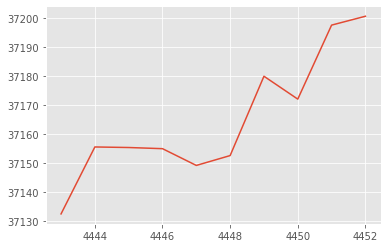

In [44]:
df['Close'][170:180].plot()

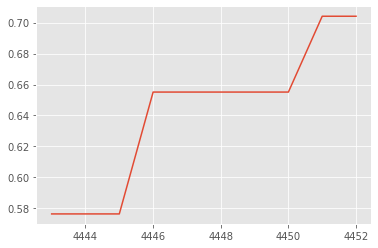

In [47]:
df['RSI5m'][170:180].plot()

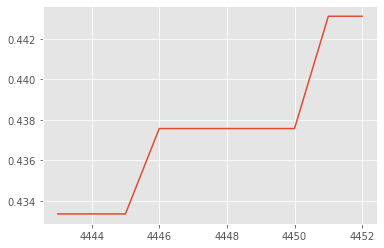

In [45]:
df['macd5m'][170:180].plot()

In [11]:
for col in df.columns:
  print(df[col])

4273      1643930040000
4274      1643930100000
4275      1643930160000
4276      1643930220000
4277      1643930280000
              ...      
172791    1654041300000
172792    1654041360000
172793    1654041420000
172794    1654041480000
172795    1654041540000
Name: Open time, Length: 168523, dtype: int64
4273      36985.00
4274      36996.22
4275      36964.57
4276      36961.94
4277      36959.76
            ...   
172791    31811.30
172792    31793.70
172793    31772.00
172794    31788.20
172795    31772.60
Name: Open, Length: 168523, dtype: float64
4273      37000.00
4274      37015.00
4275      36984.19
4276      36966.00
4277      36977.72
            ...   
172791    31831.80
172792    31793.70
172793    31801.60
172794    31802.90
172795    31797.90
Name: High, Length: 168523, dtype: float64
4273      36984.99
4274      36945.40
4275      36950.00
4276      36950.00
4277      36948.38
            ...   
172791    31793.70
172792    31763.20
172793    31771.50
172794    31772

In [12]:
df[63250:63295]

,Open time,Open,High,Low,Close,Volume,lvls_count,move_prob,vol_prob,RSI,...,MFI_divergence1h,MACD_cross1h,MACDhist_reversal1h,MACD_zerocross1h,C-O1h,H-L1h,H-O1h,C-L1h,O-L1h,H-C1h
67523,1647725100000,42248.3,42270.5,42248.2,42269.0,0.003786,0.325,0.550916,0.003786,0.610808,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67524,1647725160000,42269.0,42289.7,42268.2,42285.5,0.008644,0.150,0.548389,0.008644,0.643323,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67525,1647725220000,42285.7,42300.0,42284.5,42300.0,0.008089,0.775,0.547065,0.008089,0.670420,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67526,1647725280000,42300.0,42322.7,42286.1,42322.6,0.026174,0.075,0.552040,0.026174,0.709100,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67527,1647725340000,42322.6,42330.8,42313.4,42324.4,0.013748,0.200,0.539564,0.013748,0.712112,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67528,1647725400000,42324.4,42324.8,42296.2,42299.4,0.011746,0.225,0.523378,0.011746,0.613039,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67529,1647725460000,42299.4,42317.5,42292.6,42299.9,0.016252,0.775,0.538784,0.016252,0.614212,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67530,1647725520000,42299.9,42300.0,42289.7,42291.8,0.003931,0.175,0.533599,0.003931,0.581518,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67531,1647725580000,42291.7,42291.8,42280.0,42280.0,0.004954,0.375,0.531418,0.004954,0.534962,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172
67532,1647725640000,42280.0,42296.8,42275.1,42287.0,0.006921,0.300,0.542685,0.006921,0.557513,...,0.5,0.5,0.5,0.5,0.465182,0.091625,0.078092,0.051437,0.051437,0.143172


In [13]:
df_test=get_df(['1m', '5m', '15m', '1h'],['06'])

--2022-08-21 19:58:28--  https://data.binance.vision/data/futures/um/monthly/klines/BTCUSDT/1m/BTCUSDT-1m-2022-06.zip
Resolving data.binance.vision (data.binance.vision)... 99.86.224.111, 99.86.224.106, 99.86.224.18, ...
Connecting to data.binance.vision (data.binance.vision)|99.86.224.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1814853 (1.7M) [binary/octet-stream]
Saving to: ‘BTCUSDT-1m-2022-06.zip’

BTCUSDT-1m-2022-06. 100%[===================>]   1.73M  1.99MB/s    in 0.9s    

2022-08-21 19:58:29 (1.99 MB/s) - ‘BTCUSDT-1m-2022-06.zip’ saved [1814853/1814853]

Archive:  BTCUSDT-1m-2022-06.zip
  inflating: BTCUSDT-1m-2022-06.csv  
     adding features to 1m...

 updating data...
currency pair: BTCUSDT start: 2022-08-21 00:00:00+00:00 end: 2022-08-22 00:00:00+00:00

 updating data...
currency pair: BTCUSDT start: 2022-08-21 00:00:00+00:00 end: 2022-08-22 00:00:00+00:00
--2022-08-21 19:59:45--  https://data.binance.vision/data/futures/um/monthly/klines

In [14]:
df_test

,Open time,Open,High,Low,Close,Volume,lvls_count,move_prob,vol_prob,RSI,...,MFI_divergence1h,MACD_cross1h,MACDhist_reversal1h,MACD_zerocross1h,C-O1h,H-L1h,H-O1h,C-L1h,O-L1h,H-C1h
4272,1654297980000,29696.1,29703.5,29696.1,29697.4,0.003221,0.303030,0.590828,0.003221,0.463096,...,0.5,0.5,0.5,0.5,0.535786,0.020051,0.046641,0.016257,0.016257,0.044471
4273,1654298040000,29697.5,29697.5,29685.0,29686.4,0.002865,0.242424,0.581144,0.002865,0.388312,...,0.5,0.5,0.5,0.5,0.535786,0.020051,0.046641,0.016257,0.016257,0.044471
4274,1654298100000,29686.4,29691.0,29677.9,29678.0,0.002492,0.454545,0.583256,0.002492,0.340875,...,0.5,0.5,0.5,0.5,0.535786,0.020051,0.046641,0.016257,0.016257,0.044471
4275,1654298160000,29677.9,29693.0,29656.0,29687.7,0.008062,0.333333,0.597428,0.008062,0.432940,...,0.5,0.5,0.5,0.5,0.535786,0.020051,0.046641,0.016257,0.016257,0.044471
4276,1654298220000,29687.6,29687.7,29665.3,29672.8,0.003854,0.272727,0.578243,0.003854,0.350791,...,0.5,0.5,0.5,0.5,0.535786,0.020051,0.046641,0.016257,0.016257,0.044471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41754,1656633300000,19826.9,19845.3,19731.6,19741.5,0.144980,0.121212,0.489685,0.144980,0.848149,...,0.5,0.5,0.5,0.5,0.561729,0.076364,0.090473,0.061110,0.061110,0.050242
41755,1656633360000,19741.5,19830.0,19731.6,19826.7,0.121952,0.151515,0.689266,0.121952,0.877032,...,0.5,0.5,0.5,0.5,0.561729,0.076364,0.090473,0.061110,0.061110,0.050242
41756,1656633420000,19826.6,19829.9,19770.4,19800.6,0.064181,0.242424,0.559344,0.064181,0.835757,...,0.5,0.5,0.5,0.5,0.561729,0.076364,0.090473,0.061110,0.061110,0.050242
41757,1656633480000,19800.5,19863.9,19767.5,19853.9,0.107953,0.121212,0.651963,0.107953,0.856199,...,0.5,0.5,0.5,0.5,0.561729,0.076364,0.090473,0.061110,0.061110,0.050242


In [15]:
def Write_to_file(Date, net_worth, filename='{}.txt'.format(dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
  datestr=''
  for i in net_worth:
    #print(i)
    datestr += " {}".format(str(i))
    #print(Date)
  if not os.path.exists('logs'):
    os.makedirs('logs')
  file = open("logs/"+filename, 'a+')
  file.write(datestr+"\n")
  file.close()

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        #self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

    # Render the environment to the screen
    def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date, unit='ms')])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.015/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'], unit='ms')])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'open_long':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='white', label='white', s = 180, edgecolors='green', marker="^")
                elif trade['type'] == 'open_short':
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='white', label='white', s = 180, edgecolors='red', marker="v")
                elif trade['type'] == 'close_long':
                    high_low = trade['High']+10
                    self.ax1.scatter(trade_date, high_low, c='black', label='black', s = 180, edgecolors='red', marker="v")
                elif trade['type'] == 'close_short':
                    high_low = trade['Low']-10
                    self.ax1.scatter(trade_date, high_low, c='black', label='black', s = 180, edgecolors='green', marker="^")

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.0001)
        output.clear()
        #time.sleep(1)

        """Display image with OpenCV - no interruption"""
        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        cv2_imshow(image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return

In [48]:
class CustomEnv:
    def __init__(self, df, initial_balance=100, init_postition_size=10, leverage=125, max_steps=0, lookback_window_size=240, Render_range=120, visualize=False):
        self.df = df.dropna().reset_index()
        self.df.drop(columns=['index'], inplace=True)
        print('Feature list in df: ', end=' ')
        for col in self.df.columns:
          print(col, end=", ")
        print()
        self.df_total_steps = len(self.df)-1
        self.max_steps = max_steps
        self.initial_balance = initial_balance
        self.balance = initial_balance-init_postition_size
        self.position_size = init_postition_size
        self.init_postition_size = init_postition_size
        self.leverage = leverage
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range
        self.visualize = visualize

        # features(col names) to exclude from env state
        self.exclude_list=['Open time', 'Open', 'High', 'Low', 'Close']

        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1, 2])
        self.action_space_n = len(self.action_space)

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        # State size contains Market+Orders history for the last lookback_window_size steps
        self.state_size = (self.lookback_window_size, len(self.df.columns)+5)

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        if self.max_steps>0: env_steps_size=self.max_steps
        if self.visualize: 
          self.trades = []
          self.visualization = TradingGraph(Render_range=self.Render_range) # init visualization
        self.position_size=0
        self.balance=self.initial_balance
        self.qty=0
        self.enter_price=None
        self.in_position=False
        self.in_position_log=[self.in_position, self.in_position]
        #self.in_position_counter=0
        self.pnl=0
        self.episode_orders = 0
        self.good_trades_count=1
        self.good_trades=[]
        self.bad_trades_count=1
        self.bad_trades=[]
        self.pnl_list=[self.pnl,self.pnl]
        self.cumulative_pnl=0
        self.balance_history=[self.balance,self.balance]
        self.reward=0

        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps)
            self.end_step = self.df_total_steps
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.position_size, self.balance, self.in_position, self.qty, self.cumulative_pnl, self.pnl, self.enter_price])
            self.market_history.append([self.df.loc[self.current_step, col_name] for col_name in self.df.columns if col_name not in self.exclude_list])
            #print(i, end=': ')
            #print()
            #print(self.orders_history[-1])
            #print(self.market_history[-1])

        state = np.concatenate((self.market_history, self.orders_history), axis=1)
        #print(state)
        return state

    # Get the data points for the given current_step
    def _next_observation(self):
      self.market_history.append([self.df.loc[self.current_step, col_name] for col_name in self.df.columns if col_name not in self.exclude_list])
      obs = np.concatenate((self.market_history, self.orders_history), axis=1)
      #print(obs)
      #time.sleep(120)
      return obs
    
    def _calculate_reward(self):
      ###### Profit closing ######
      if (not self.in_position) and self.in_position_log[-2]==True and (self.position_size>round(self.init_postition_size*0.999, 2)):
        self.good_trades_count+=1
        self.good_trades.append(self.position_size/round(self.init_postition_size*0.999, 2)-1)
        if self.cumulative_pnl>0:
          self.reward=self.cumulative_pnl
        elif self.cumulative_pnl<0:
          self.cumulative_pnl=(-1)*self.cumulative_pnl
        #self.reward=(self.balance/self.balance_history[-2]-1)+abs(self.cumulative_pnl)*1
        #self.reward=2+(self.bad_trades_count/self.good_trades_count)+self.orders_history[-2][-2]
        self.reward=2+(self.bad_trades_count/self.good_trades_count)+self.cumulative_pnl
      ###### Loss closing ######
      elif (not self.in_position) and self.in_position_log[-2]==True and (self.position_size<round(self.init_postition_size*0.999, 2)):
        self.bad_trades_count+=1
        self.bad_trades.append(self.position_size/round(self.init_postition_size*0.999, 2)-1)
        if self.cumulative_pnl<0:
          self.reward=self.cumulative_pnl
        elif self.cumulative_pnl>0:
          self.cumulative_pnl=(-1)*self.cumulative_pnl
        #self.reward=(self.balance_history[-2]/self.balance-1)*(-1)-abs(self.cumulative_pnl)*1
        #self.reward=1/abs(self.cumulative_pnl)
        #self.reward=-2-(self.bad_trades_count/self.good_trades_count)+self.orders_history[-2][-2]
        self.reward=-2-(self.bad_trades_count/self.good_trades_count)+self.cumulative_pnl
      ###### Holding position ######
      #elif self.pnl<0 and self.pnl_list[-2]>0:
        #if self.cumulative_pnl<0:
          #self.cumulative_pnl=self.cumulative_pnl
          #self.reward=self.cumulative_pnl
        #elif self.cumulative_pnl>0:
          #self.cumulative_pnl=(-1)*self.cumulative_pnl
          #self.cumulative_pnl=self.cumulative_pnl
          #self.reward=self.cumulative_pnl
        #self.reward=self.pnl
        #self.reward=self.pnl-self.pnl_list[-2]
      #elif self.pnl>0 and self.pnl_list[-2]<0:
        #self.reward=self.pnl*10
        #self.cumulative_pnl=0
        #self.reward=self.pnl
        #self.reward=self.pnl-self.pnl_list[-2]
      elif self.in_position:
        #self.reward=0
        self.reward=self.pnl
        '''if self.pnl>0:
          if self.cumulative_pnl>0:
            self.reward=self.cumulative_pnl/self.in_position_counter
          elif self.cumulative_pnl<0:
            self.cumulative_pnl=(-1)*self.cumulative_pnl
            self.cumulative_pnl=self.cumulative_pnl
            self.reward=self.cumulative_pnl/self.in_position_counter
        elif self.pnl<0:
          if self.cumulative_pnl<0:
            self.reward=self.cumulative_pnl
          elif self.cumulative_pnl>0:
            self.cumulative_pnl=(-1)*self.cumulative_pnl
            self.cumulative_pnl=self.cumulative_pnl
            self.reward=self.cumulative_pnl
        else:
          self.reward=self.pnl'''
      else:
        #self.reward=self.cumulative_pnl
        #self.reward=self.pnl
        self.reward=0
      return self.reward

    def _get_pnl(self, current_price):
      self.pnl=(((current_price/self.enter_price)-1)*self.leverage)*self.qty
      self.pnl_list.append(self.pnl)
      if self.cumulative_pnl>0 and len(self.pnl_list)>1:
        self.cumulative_pnl+=(self.pnl-self.pnl_list[-2])
      else:
        self.cumulative_pnl+=self.pnl
      #self.cumulative_pnl+=self.pnl
      return self.pnl

    def _finish_episode(self, penalty=True):
      self.orders_history.append([self.position_size, self.balance, self.in_position, self.qty, self.cumulative_pnl, self.pnl, self.enter_price])
      self._calculate_reward()
      done=True
      obs = self._next_observation()
      if len(self.balance_history)>0 and len(self.good_trades)>0 and len(self.bad_trades)>0:
        print('')
        print(f' Koncowy balans: ${self.balance:.2f} Sredni balans: ${mean(self.balance_history):.2f} Max balans: ${max(self.balance_history):.2f} zyskownych:{self.good_trades_count:} ({mean(self.good_trades)*100:.1f}%) stratnych:{self.bad_trades_count} ({mean(self.bad_trades)*100:.1f}%)')
      else:
        print('')
        print(f' Koncowy balans: ${self.balance:.2f} Max balans: ${max(self.balance_history):.2f} zyskownych:{self.good_trades_count} stratnych:{self.bad_trades_count}')
      info = {'action': 0,
              'reward': self.reward,
              'step': self.current_step}
      return obs, mean(self.balance_history)-self.initial_balance, done, info

    def _open_position(self, side, price):
      self.in_position=True
      self.in_position_log.append(self.in_position)
      self.episode_orders += 1
      self.enter_price=price
      #print(f' BEFORE self.position_size: {self.position_size}')
      #print(f' BEFORE self.balance: {self.balance}')
      self.position_size = round(self.init_postition_size*0.999, 2)
      self.balance-=self.init_postition_size
      #print(f' AFTER self.position_size: {self.position_size}')
      #print(f' AFTER self.balance: {self.balance}')
      self.balance_history.append(self.balance)
      if side=='long':
        self.qty = 1  #*(self.position_size/self.enter_price)
      elif side=='short':
        self.qty= -1  #(self.position_size/self.enter_price)

    def _close_position(self):
      self.qty = 0
      self.in_position=False
      self.in_position_log.append(self.in_position)
      #self.in_position_counter=0
      if self.pnl>0:
        self.good_trades_count += 1
      elif self.pnl<0:
        self.bad_trades_count += 1
      #print(f' self.pnl: {self.pnl}')
      #print(f' BEFORE self.position_size: {self.position_size}')
      #print(f' BEFORE self.balance: {self.balance}')
      self.position_size += round((self.position_size*self.pnl)*0.999, 2)
      self.balance += self.position_size
      if self.balance>self.initial_balance: self.init_postition_size=round(self.balance/10, 2)
      #print(f' AFTER self.position_size: {self.position_size}')
      #print(f' AFTER self.balance: {self.balance}')
      self.balance_history.append(self.balance)
      self.pnl = 0
      self.cumulative_pnl = 0
    
    # Execute one time step within the environment
    def step(self, action):
        self.current_step += 1
        if self.current_step==self.end_step:
          return self._finish_episode(penalty=False)
        done=False
        self.in_position_log.append(self.in_position)
        close=self.df.loc[self.current_step, 'Close']
        current_price = random.uniform(round(close*1.0002, 2), round(close*0.9998, 2))
        #current_price=self.df.loc[self.current_step, 'Close']
        #current_price = random.uniform(self.df.loc[self.current_step, 'High'], self.df.loc[self.current_step, 'Low'])
        ########################## VISUALIZATION ###############################
        if self.visualize:
          Date = self.df.loc[self.current_step, 'Open time']
          High = self.df.loc[self.current_step, 'High']
          Low = self.df.loc[self.current_step, 'Low']
        ########################################################################
        if self.in_position:
          self._get_pnl(current_price)
          if self.pnl<=-0.9:
            self._close_position()
            #return self._finish_episode()
          else:
            ##CLOSING POSTIONS OR PASS##
            if action == 0:
              #print('IN POSITION PASS')
              pass
            # Close SHORT or LONG qty={-1,0,1}
            elif (action==1 and self.qty<0) or (action==2 and self.qty>0):
              #print('CLOSING POSITION')
              self._close_position()
              ########################## VISUALIZATION ###############################
              if self.visualize and action==1:  self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.qty, 'type': "close_short"})
              elif self.visualize and action==2:  self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.qty, 'type': "close_long"})
              ########################################################################
              if self.balance*0.999<=self.init_postition_size:
                return self._finish_episode()
        ##OPENING POSTIONS OR PASS##
        else:
          if action == 0:
            #print('NO POSITION PASS')
            pass
          # OPEN LONG
          elif self.balance*0.999<=self.init_postition_size:
            return self._finish_episode()
          elif action == 1:
            #print('OPENING LONG')
            self._open_position('long', current_price)
            if self.visualize: self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.qty, 'type': "open_long"})
          # OPEN SHORT
          elif action == 2:
            #print('OPENING SHORT')
            self._open_position('short', current_price)
            if self.visualize: self.trades.append({'Date' : Date, 'High' : High, 'Low' : Low, 'total': self.qty, 'type': "open_short"})
        
        self.orders_history.append([self.position_size, self.balance, self.in_position, self.qty, self.cumulative_pnl, self.pnl, self.enter_price])
        #if self.in_position: self.in_position_counter+=1
        #Write_to_file(Date, self.orders_history[-1])
        self._calculate_reward()
        obs = self._next_observation()
        info = {'action': action,
                'reward': self.reward,
                'step': self.current_step}
        return obs, self.reward, done, info

    # render environment
    def render(self, visualize=False, *args, **kwargs):
      if visualize or self.visualize:
        Date = self.df.loc[self.current_step, 'Open time']
        Open = self.df.loc[self.current_step, 'Open']
        Close = self.df.loc[self.current_step, 'Close']
        High = self.df.loc[self.current_step, 'High']
        Low = self.df.loc[self.current_step, 'Low']
        Volume = self.reward
        # Render the environment to the screen
        self.visualization.render(Date, Open, High, Low, Close, Volume, self.balance, self.trades)

lookback_window_size = 60

train_env = CustomEnv(df, lookback_window_size=lookback_window_size, max_steps=4320, visualize=True, initial_balance=100, leverage=50)
test_env = CustomEnv(df_test, lookback_window_size=lookback_window_size, max_steps=1440, visualize=True, initial_balance=100, leverage=50)

def build_model(states, actions, neurons, n_layers, window_length, lookback_window_size):
    model = Sequential()
    model.add(Flatten(input_shape=(window_length,lookback_window_size,states)))
    #model.add(Reshape((lookback_window_size, states), input_shape=(window_length, lookback_window_size, states)))
    #model.add(LSTM(neurons, return_sequences = True, input_shape=(lookback_window_size, states), activation = 'relu'))
    #model.add(Dense(states, activation='relu'))
    #model.add(Flatten(input_shape=(window_length,lookback_window_size,states)))
    for _ in range(n_layers):
      model.add(Dense(neurons, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model
def build_agent(model, actions, window_length, lookback_window_size, policy=EpsGreedyQPolicy()):
    #policy = BoltzmannQPolicy()
    test_policy=policy
    memory = SequentialMemory(limit=100*window_length, window_length=window_length)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, test_policy=test_policy,
                  nb_actions=actions, nb_steps_warmup=lookback_window_size*10, target_model_update=1e-1, enable_double_dqn=True, enable_dueling_network=True, dueling_type='avg')
    return dqn

Feature list in df:  Open time, Open, High, Low, Close, Volume, lvls_count, move_prob, vol_prob, RSI, ULT, ADX, -DI, +DI, macd, macdsignal, macdhist, ADOSC, APO, AROONOSC, STOCHRSIfastk, STOCHRSIfastd, CMO, BOP, TRANGE, PPO, WILLR, KST, Vortex, STC, PVO, AO, RSI_sig, ULT_sig, ADX_sig, ADX_trend, MFI_strat, MFI_divergence, MACD_cross, MACDhist_reversal, MACD_zerocross, C-O, H-L, H-O, C-L, O-L, H-C, lvls_count5m, move_prob5m, vol_prob5m, RSI5m, ULT5m, ADX5m, -DI5m, +DI5m, macd5m, macdsignal5m, macdhist5m, ADOSC5m, APO5m, AROONOSC5m, STOCHRSIfastk5m, STOCHRSIfastd5m, CMO5m, BOP5m, TRANGE5m, PPO5m, WILLR5m, KST5m, Vortex5m, STC5m, PVO5m, AO5m, RSI_sig5m, ULT_sig5m, ADX_sig5m, ADX_trend5m, MFI_strat5m, MFI_divergence5m, MACD_cross5m, MACDhist_reversal5m, MACD_zerocross5m, C-O5m, H-L5m, H-O5m, C-L5m, O-L5m, H-C5m, lvls_count15m, move_prob15m, vol_prob15m, RSI15m, ULT15m, ADX15m, -DI15m, +DI15m, macd15m, macdsignal15m, macdhist15m, ADOSC15m, APO15m, AROONOSC15m, STOCHRSIfastk15m, STOCHRSIfast

In [ ]:
n_windows=1
#n_count=8192
n_layers=5
policy=EpsGreedyQPolicy()

window_sizes=list(range(1,10,1))
scores_l=[]
for window in window_sizes:
      train_env = CustomEnv(df, lookback_window_size=window, max_steps=3000, visualize=True, initial_balance=20, init_postition_size=2.0, leverage=125)
      test_env = CustomEnv(df_test, lookback_window_size=window, max_steps=20_000, visualize=True, initial_balance=20, init_postition_size=2.0, leverage=125)
      n_count=int(window*len(df.columns)+3//2)

      model = build_model(len(train_env.reset()[-1]), train_env.action_space_n, n_count, n_layers, n_windows, window)
      #model.summary()
      dqn = build_agent(model, train_env.action_space_n, n_windows, window, policy=policy)
      dqn.compile(Adam(learning_rate=1e-5), metrics=[tf.keras.metrics.RootMeanSquaredError()])
      ## Callbacks:
      #tfboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
      #dqn.fit(train_env, nb_steps=100000, visualize=False, callbacks=[tfboard], verbose=2, log_interval=250)
      dqn.fit(train_env, nb_steps=25_000, visualize=False, verbose=2, log_interval=250)
  
      scores = dqn.test(test_env, nb_episodes=10, visualize=False)
      scores_l.append([n_windows,n_layers,n_count,scores])
      print("####################################################")
      print(f'n_windows: {n_windows}', end='  ')
      print(f'n_layers: {n_layers}', end='  ')
      print(f'n_count: {n_count}', end='  ')
      print(f'window: {window}')
      cv = lambda x: abs(np.std(x, ddof=1) / np.mean(x)) * 100 
      print('mediana: ', end='  ')
      print(np.median(scores.history['episode_reward']), end='  ')
      print('srednia: ', end=' ')
      print(np.mean(scores.history['episode_reward']), end='  ')
      zm=cv(scores.history['episode_reward'])
      print(f'wsp. zmiennosci: {zm:.1f}%')
      print("####################################################")

Feature list in df:  Open time, Open, High, Low, Close, Volume, lvls_count, move_prob, vol_prob, RSI, ULT, ADX, -DI, +DI, macd, macdsignal, macdhist, ADOSC, APO, AROONOSC, STOCHRSIfastk, STOCHRSIfastd, CMO, BOP, TRANGE, PPO, WILLR, KST, Vortex, STC, PVO, AO, RSI_sig, ULT_sig, ADX_sig, ADX_trend, MFI_strat, MFI_divergence, MACD_cross, MACDhist_reversal, MACD_zerocross, C-O, H-L, H-O, C-L, O-L, H-C, lvls_count5m, move_prob5m, vol_prob5m, RSI5m, ULT5m, ADX5m, -DI5m, +DI5m, macd5m, macdsignal5m, macdhist5m, ADOSC5m, APO5m, AROONOSC5m, STOCHRSIfastk5m, STOCHRSIfastd5m, CMO5m, BOP5m, TRANGE5m, PPO5m, WILLR5m, KST5m, Vortex5m, STC5m, PVO5m, AO5m, RSI_sig5m, ULT_sig5m, ADX_sig5m, ADX_trend5m, MFI_strat5m, MFI_divergence5m, MACD_cross5m, MACDhist_reversal5m, MACD_zerocross5m, C-O5m, H-L5m, H-O5m, C-L5m, O-L5m, H-C5m, lvls_count15m, move_prob15m, vol_prob15m, RSI15m, ULT15m, ADX15m, -DI15m, +DI15m, macd15m, macdsignal15m, macdhist15m, ADOSC15m, APO15m, AROONOSC15m, STOCHRSIfastk15m, STOCHRSIfast

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Training for 25000 steps ...


/usr/local/lib/python3.7/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')



 Koncowy balans: $19.97 Sredni balans: $19.61 Max balans: $23.13 zyskownych:93 (14.1%) stratnych:70 (-16.7%)
  3000/25000: episode: 1, duration: 38.018s, episode steps: 3000, steps per second:  79, episode reward: 74.892, mean reward:  0.025 [-7.000,  3.667], mean action: 0.324 [0.000, 2.000],  loss: 0.139357, root_mean_squared_error: 0.254918, mean_q: 0.065917

 Koncowy balans: $20.02 Sredni balans: $17.02 Max balans: $24.04 zyskownych:56 (39.3%) stratnych:73 (-27.3%)
  6000/25000: episode: 2, duration: 36.589s, episode steps: 3000, steps per second:  82, episode reward: 137.806, mean reward:  0.046 [-5.000,  3.757], mean action: 0.091 [0.000, 2.000],  loss: 0.172739, root_mean_squared_error: 0.301002, mean_q: 0.192676

 Koncowy balans: $22.31 Sredni balans: $22.21 Max balans: $26.84 zyskownych:63 (25.0%) stratnych:78 (-18.9%)
  9000/25000: episode: 3, duration: 37.456s, episode steps: 3000, steps per second:  80, episode reward: 130.633, mean reward:  0.044 [-3.364,  3.316], mean ac

In [ ]:
scores_l=[]
for n_windows in range(1,2):
  for n_layers in range(4,5):
    for n_count in range(3240,19440,3240):
      model = build_model(len(train_env.reset()[-1]), train_env.action_space_n, n_count, n_layers, n_windows)
      #model.summary()
      dqn = build_agent(model, train_env.action_space_n, n_windows, EpsGreedyQPolicy())
      dqn.compile(Adam(learning_rate=1e-5), metrics=['mae'])
      #tfboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
      #dqn.fit(train_env, nb_steps=20000, visualize=False, callbacks=[tfboard], verbose=2, log_interval=250)
      dqn.fit(train_env, nb_steps=20000, visualize=False, callbacks=[tfboard], verbose=2, log_interval=250)
  
      scores = dqn.test(test_env, nb_episodes=100, visualize=False)
      scores_l.append([n_windows,n_layers,n_count,scores])
      print("####################################################")
      print(f'n_windows: {n_windows}', end='  ')
      print(f'n_layers: {n_layers}', end='  ')
      print(f'n_count: {n_count}')
      cv = lambda x: abs(np.std(x, ddof=1) / np.mean(x)) * 100 
      print('mediana: ', end='  ')
      print(np.median(scores.history['episode_reward']), end='  ')
      print('srednia: ', end=' ')
      print(np.mean(scores.history['episode_reward']), end='  ')
      zm=cv(scores.history['episode_reward'])
      print(f'wsp. zmiennosci: {zm:.1f}%')
      print("####################################################")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir Graph/

In [ ]:
scores

In [ ]:
def Random_games(env, visualize=False, train_episodes = 100, training_batch_size=500):
    average_net_worth=[]
    list_of_orders=[]
    rewards=0
    list_of_rewards=[]
    list_of_mean_rewards=[]
    list_of_time=[]
    start_time=time.time()
    env.visualize=visualize
    for episode in range(train_episodes):
        print(f' ep{episode}:', end=' ')
        env.reset(env_steps_size = training_batch_size)
        while True:
            if visualize: env.render(visualize)

            action = np.random.randint(3, size=1)[0]

            state, reward, done, info = env.step(action)
            rewards+=reward
            #print(f'rewards: {rewards}')
            if env.current_step == env.end_step or done:
                average_net_worth.append(env.balance)
                #list_of_orders.append(env.orders_history)
                list_of_rewards.append(rewards)
                rewards=0
                list_of_time.append(time.time()-start_time)
                #print("net_worth:", env.net_worth)
                break
    print("AVG_time_per_episode:", mean(list_of_time))
    print("MAX_time_per_episode:", max(list_of_time))
    print("MIN_time_per_episode:", min(list_of_time))
    print("average_net_worth:", sum(average_net_worth)/train_episodes)
    print("results above initial:", sum(i > env.initial_balance for i in average_net_worth))
    print("best_net_worth:", max(average_net_worth))
    #print('best env: '+str(list_of_orders[average_net_worth.index(max(average_net_worth))]))
    print(f'Indeks najlepszego: {average_net_worth.index(max(average_net_worth))}')
    cv = lambda x: abs(stdev(x) / mean(x)) * 100 
    print('mediana: ', end='  ')
    print(median(list_of_rewards), end='  ')
    print('srednia: ', end=' ')
    print(mean(list_of_rewards), end='  ')
    print('wsp. zmiennosci: ', end='  ')
    print(cv(list_of_rewards), end='%  ')
    return list_of_rewards

In [ ]:
train_env = CustomEnv(df, lookback_window_size=5, max_steps=18_000, visualize=True, initial_balance=20, init_postition_size=2.0, leverage=125)
najlpeszy = Random_games(train_env, visualize=False, train_episodes=10, training_batch_size=18_000)
#mean(najlpeszy)